In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import datetime
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import pdb
from hmmlearn import hmm

# Machine learning package
from sklearn import metrics, preprocessing
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Convolution1D
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D,Reshape

from keras import models
from keras import layers
from keras import optimizers
from keras.wrappers import scikit_learn

Using TensorFlow backend.


### Data pre-processing

In [2]:
underlying = 'BA'#Boeing company
st = '2016-01-01'
et = '2019-01-01'

data = pdr.get_data_yahoo(underlying,st,et)
data = data.dropna()

data['S_10'] = data['Close'].rolling(window=10).mean()
data['RSI'] = ta.RSI(np.array(data['Close']), timeperiod =10)
data['Open-Close'] = data['Open'] -data['Close'].shift(1) #shift(1)向后移动， shift(-1)向前移动  今天-昨天
data['Open-Open'] = data['Open'] - data['Open'].shift(1) #今天的open - 昨天的open
data['MOM']=ta.MOM(data.Close, timeperiod=5)
data['ADX'] = ta.ADX(data.High, data.Low, data.Close, timeperiod=14)
data['ROC'] = ta.ROC(data.Close, timeperiod=10)
data['BETA'] = ta.BETA(data.High, data.Low, timeperiod=5)
data['OBV'] = ta.OBV(data.Close, data.Volume)
data['NReturn'] = data['Adj Close'].shift(-1)-data['Adj Close']/data['Adj Close']

data =data.dropna()
factors =data.columns[-10:-1]
n_factors = len(factors)
print(n_factors)

print(data.head())
print('factors:',factors)

9
                  High         Low        Open       Close      Volume  \
Date                                                                     
2016-02-10  119.459999  116.269997  118.160004  116.360001   4888600.0   
2016-02-11  113.400002  102.099998  113.180000  108.440002  33735600.0   
2016-02-12  109.839996  105.000000  105.120003  108.629997  12973400.0   
2016-02-16  112.760002  109.000000  109.730003  112.599998   7587700.0   
2016-02-17  116.830002  113.989998  114.029999  116.339996   6619600.0   

             Adj Close        S_10        RSI  Open-Close  Open-Open  \
Date                                                                   
2016-02-10  104.513908  119.996999  32.798752   -0.719994   0.180000   
2016-02-11   97.400223  119.039999  24.402503   -3.180000  -4.980003   
2016-02-12   97.570869  117.889999  24.914840   -3.320000  -8.059998   
2016-02-16  101.136703  116.993999  35.122971    1.100006   4.610001   
2016-02-17  104.495949  116.875999  43.205325  

In [3]:
# Feature Scaling
# training_set
sc = MinMaxScaler(feature_range = (0, 1))
training_set=data[:-200]
training_set=pd.DataFrame(training_set)
training_set_scaled = sc.fit_transform(training_set)
# print(training_set.shape)

#test_set
test_set = data[-200:]
test_set = pd.DataFrame(test_set)
test_set_scaled = sc.fit_transform(test_set)
# print(test_set_scaled.shape)

In [4]:
lookback = 10

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(lookback, len(training_set_scaled)):
    X_train.append(training_set_scaled[i - lookback:i,6:15])
    y_train.append(training_set_scaled[i,5])

X_train, y_train = np.array(X_train), np.array(y_train)
# print(X_train.shape)
# print(n_factors)

# Reshaping
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1],n_factors))
# print(X_train.shape)
# print(y_train.shape)

In [5]:
#X_test y_test
inputs = data[len(data) - len(test_set) - lookback:].values
print(inputs.shape)
# inputs = inputs.reshape(-1,n_factors)
inputs = sc.transform(inputs)
X_test = []
for i in range(lookback, len(inputs)):
    X_test.append(inputs[i-lookback:i, 6:15])

real_stock_price = np.array(test_set_scaled[:,2].tolist())
print(real_stock_price.shape)

(210, 16)
(200,)


In [6]:
# Initialising the RNN
def create_model():
    regressor = Sequential()
    regressor.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1],n_factors)))
#     regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss='mse',metrics=["accuracy"])
    return regressor

rnn_model = scikit_learn.KerasRegressor(build_fn=create_model, verbose=1)

In [7]:
# param Fine Tune

# 设置参数候选值
# batch_size,epochs 
batch_size = [8,16]
epochs = [1,5]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
learn_rate = [0.001, 0.01, 0.1]
# init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
# init_mode = ['uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

# 创建GridSearchCV，并训练
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator= rnn_model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_train, y_train)

# 打印结果
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
 
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))


Epoch 1/1
104/104 [==============================] - 0s 469us/step
Epoch 1/1
104/104 [==============================] - 0s 479us/step
Epoch 1/1
103/103 [==============================] - 0s 476us/step
Epoch 1/1
103/103 [==============================] - 0s 483us/step
Epoch 1/1
103/103 [==============================] - 0s 465us/step
Epoch 1/5
413/413 [==============================] - 0s 984us/step - loss: 0.0254 - accuracy: 0.0000e+00
Epoch 2/5
413/413 [==============================] - 0s 355us/step - loss: 8.2057e-04 - accuracy: 0.0024
Epoch 3/5
413/413 [==============================] - 0s 350us/step - loss: 5.0472e-04 - accuracy: 0.0024
Epoch 4/5
413/413 [==============================] - 0s 358us/step - loss: 3.6864e-04 - accuracy: 0.0024
Epoch 5/5
104/104 [==============================] - 0s 491us/step
Epoch 1/5
413/413 [==============================] - 0s 964us/step - loss: 0.0054 - accuracy: 0.0024
Epoch 2/5
413/413 [==============================] - 0s 371us/step - loss: 6.

In [91]:
# optimizer
def create_model2(optimizer='adam'):
    # create model
    regressor = Sequential()
    regressor.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], n_factors)))
    regressor.add(Dense(1))
    # Compile model
    regressor.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return regressor

rnn_model2 = scikit_learn.KerasRegressor(build_fn=create_model2, epochs=1, batch_size=8, verbose=1)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid2 = dict(optimizer=optimizer)
grid2 = GridSearchCV(estimator=rnn_model2, param_grid=param_grid2, n_jobs=1, cv=3)
grid_result2 = grid2.fit(X_train,y_train)

# summarize results
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/1
558/558 [==============================] - 1s 1ms/step
Epoch 1/1
557/557 [==============================] - 1s 1ms/step
Epoch 1/1
557/557 [==============================] - 1s 1ms/step
Epoch 1/1
558/558 [==============================] - 1s 1ms/step
Epoch 1/1
557/557 [==============================] - 1s 1ms/step
Epoch 1/1
557/557 [==============================] - 1s 1ms/step
Epoch 1/1
558/558 [==============================] - 1s 1ms/step
Epoch 1/1
557/557 [==============================] - 1s 1ms/step
Epoch 1/1
557/557 [==============================] - 1s 1ms/step
Epoch 1/1
558/558 [==============================] - 1s 1ms/step
Epoch 1/1
557/557 [==============================] - 1s 1ms/step
Epoch 1/1
557/557 [==============================] - 1s 1ms/step
Epoch 1/1
558/558 [==============================] - 1s 1ms/step
Epoch 1/1
557/557 [==============================] - 1s 1ms/step
Epoch 1/1
557/557 [==============================] - 1s 1ms/step
Epoch 1/1
558/558 [======

In [8]:
# learning rate
from keras.optimizers import Adam
def create_model3(learn_rate=0.001):
    # create model
    regressor = Sequential()
    regressor.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], n_factors)))
    regressor.add(Dense(1))
    # Compile model
    optimizer = Adam(lr=learn_rate)
    regressor.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return regressor

rnn_model3 = scikit_learn.KerasRegressor(build_fn=create_model3, epochs=1, batch_size=8, verbose=0)
param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator = rnn_model3, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.898929 using {'learn_rate': 0.001}
-0.898929 (0.298060) with: {'learn_rate': 0.001}
-4.043270 (4.412754) with: {'learn_rate': 0.01}
-7.631585 (4.572817) with: {'learn_rate': 0.1}


In [9]:
# weight initialization
def create_model4(init_mode='uniform'):
    regressor = Sequential()
    regressor.add(LSTM(50, activation='relu',kernel_initializer=init_mode, input_shape=(X_train.shape[1], n_factors)))
    regressor.add(Dense(1,kernel_initializer=init_mode))
    optimizer = Adam(lr=0.01)
    regressor.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return regressor
# create model
rnn_model4 = scikit_learn.KerasRegressor(build_fn=create_model4, epochs=1, batch_size=8, verbose=0)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=rnn_model4, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -2.044130 using {'init_mode': 'normal'}
-3.776712 (4.593476) with: {'init_mode': 'uniform'}
-3.674414 (4.581777) with: {'init_mode': 'lecun_uniform'}
-2.044130 (1.296062) with: {'init_mode': 'normal'}
-5.144398 (3.772904) with: {'init_mode': 'zero'}
-3.029737 (3.637941) with: {'init_mode': 'glorot_normal'}
-4.033828 (4.417824) with: {'init_mode': 'glorot_uniform'}
-4.818447 (4.117739) with: {'init_mode': 'he_normal'}
-4.817435 (4.118845) with: {'init_mode': 'he_uniform'}


#### best model

In [18]:
# best param
epoch=50
batch_size=100
#     regressor.add(Dropout(0.2))
def create_model5(init_mode='glorot_normal',lr=0.001):
    regressor = Sequential()
    regressor.add(LSTM(50, activation='relu',return_sequences = True, input_shape=(X_train.shape[1], n_factors)))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(1,kernel_initializer=init_mode))
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],n_factors)))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],n_factors)))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    regressor.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1],n_factors)))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))

    optimizer = Adam(lr=lr)
    regressor.compile(loss='mse', optimizer=optimizer)
    return regressor
# create model
rnn_model5 = scikit_learn.KerasRegressor(build_fn=create_model5, epochs=epoch, batch_size=batch_size, verbose=1)
# define the grid search parameters
lstm = rnn_model5.fit(X_train,y_train)
print(lstm.history)

Epoch 1/50
517/517 [==============================] - 2s 3ms/step - loss: 0.1680
Epoch 2/50
517/517 [==============================] - 0s 318us/step - loss: 0.1223
Epoch 3/50
517/517 [==============================] - 0s 293us/step - loss: 0.0760
Epoch 4/50
517/517 [==============================] - 0s 278us/step - loss: 0.0821
Epoch 5/50
517/517 [==============================] - 0s 284us/step - loss: 0.0719
Epoch 6/50
517/517 [==============================] - 0s 294us/step - loss: 0.0726
Epoch 7/50
517/517 [==============================] - 0s 276us/step - loss: 0.0673
Epoch 8/50
517/517 [==============================] - 0s 291us/step - loss: 0.0591
Epoch 9/50
517/517 [==============================] - 0s 322us/step - loss: 0.0367
Epoch 10/50
517/517 [==============================] - 0s 330us/step - loss: 0.0103
Epoch 11/50
517/517 [==============================] - 0s 331us/step - loss: 0.0132
Epoch 12/50
517/517 [==============================] - 0s 332us/step - loss: 0.0081
Epo

(200, 10, 9)
200/200 [==============================] - 0s 793us/step


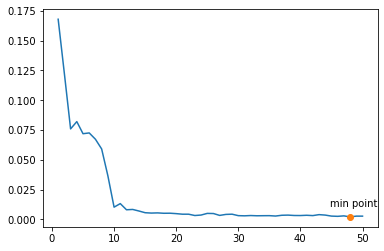

In [19]:
plt.plot(range(1,epoch+1),lstm.history['loss'])
plt.plot(np.argmin(lstm.history['loss'])+1,min(lstm.history['loss']),'o')
plt.annotate('min point',xy=(np.argmin(lstm.history['loss'])+1,min(lstm.history['loss'])),xytext=(-20,10),textcoords='offset points')

#prediction
X_test = np.array(X_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_factors))
predicted_stock_price = rnn_model5.predict(X_test)


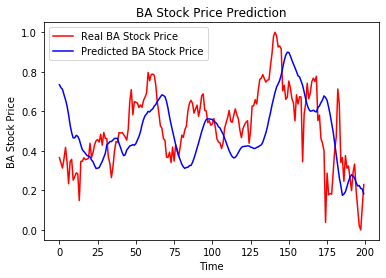

In [20]:
# Visualising the results
def visualize(real_stock_price,predicted_stock_price):
    plt.plot(real_stock_price, color = 'red', label = 'Real BA Stock Price')
    plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted BA Stock Price')
    plt.title('BA Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('BA Stock Price')
    plt.legend()
    plt.show()
    
visualize(real_stock_price,predicted_stock_price)

In [21]:
# calculate the return of the predicted price and real price
def cal_ret(ser):
    return pd.Series(ser).pct_change()
# calculate the win_rate of the predicted return
def win_rate(pred, real):
    res = round(sum(np.sign(pred)==np.sign(real))/len(pred), 3)
    print('win_rate:',res)
    return res

pred_ret = cal_ret(predicted_stock_price)
rel_ret = cal_ret(real_stock_price)
pred_ret = pred_ret[~np.isnan(pred_ret)]
rel_ret = rel_ret[~np.isnan(rel_ret)]
win = win_rate(pred_ret, rel_ret)
rel_ret[np.isinf(rel_ret)] = 0
np.corrcoef(pred_ret, rel_ret)

win_rate: 0.497


array([[ 1.        , -0.07190612],
       [-0.07190612,  1.        ]])